# Simple Feedforward NN model

### Variables
- `max_len`: max sentence size in #words
- `n_class`: number of classes, 2 for fake and real news

### Structure
- Pretrained embedding layer
- Take average of title's embedding vector
- A few linear+ReLu layers with dropout
- Softmax for one hot vector output, classification probabilities

In [1]:
max_len = 20 # max number of words in a sentence, average+2*std of fake news (longer than real news)
n_class = 2 # 1: fake, 0: not fake

In [2]:
#import freq_utils
from freq_utils import *

#import pandas as pd

pd.options.display.max_colwidth = 200

In [3]:
#x = np.zeros((10, max_len, 50))
#emb_dim = x.shape[2]
#a = [ x[:,:,i] for i in range(emb_dim) ]
#y = tf.keras.layers.Average()(a)
#print(type(y),y)
#print(y.shape,y[:,1])

In [4]:
df0 = pd.read_csv('data/True.csv')
df1 = pd.read_csv('data/Fake.csv')

df0['label'] = 0
df1['label'] = 1

print(len(df0),len(df1))

train, dev, test = train_dev_test_split([df0, df1], m=10000, class_column='label', 
                                    class_balance=True, r_dev=0.2, r_test=0.2, rand_state=42)

21417 23481


In [5]:
word_to_index, index_to_word, word_to_vec_map = get_pretrained_embedding()

In [6]:
def df_to_xy(df, word_to_index, max_len):
    
    #X = df.title.str.replace(r'[^\s\w]', '',regex=True).to_numpy()
    indx = df.index.to_numpy() 
    X = df.title.to_numpy()
    Y = df.label.to_numpy()
    X_indices = sentences_to_indices(X, word_to_index, max_len)
    Y_oh = pd.get_dummies(df['label']).to_numpy()
    
    return indx, X, X_indices, Y, Y_oh

_, X_train, X_train_indices, Y_train, Y_train_oh = df_to_xy(train, word_to_index, max_len)
_, X_dev,   X_dev_indices,   Y_dev,   Y_dev_oh   = df_to_xy(dev, word_to_index, max_len)
indx_test, X_test,  X_test_indices,  Y_test,  Y_test_oh  = df_to_xy(test, word_to_index, max_len)

In [7]:
def simple_FNN(input_shape, word_to_vec_map, word_to_index, n_class=2):
    '''
    input_shape: (max_len,)
    word_to_vec_map: word to embedding vector dictionary
    word_to_index: word to index dictionary
    
    return model
    
    then
    X: Indices of a sentence (m, max_len)
    Y: Class probability, one hot vector (m, # classes)
    '''
    
    # Input layer
    X_indices = tfl.Input(shape=input_shape, dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index, trainable=True)
    X = embedding_layer(X_indices)   
    
    # Masking layer
    # skip zero vector words
    X = tfl.Masking(mask_value=0.)(X)
    
    # Take average
    # Get embedding vector dimension
    #emb_dim = X.shape[2]
    max_len = X.shape[1]
    # Make a list from slice
    X_avg = [ X[:,i,:] for i in range(max_len) ]
    # Take average of embedding vector
    X = tf.keras.layers.Average()(X_avg)
        
    # Linear+ReLu layer
    X = tfl.Dense(units = 128, activation='relu')(X)
    X = tfl.Dropout(rate = 0.4)(X)  
    
    # Linear+ReLu layer
    X = tfl.Dense(units = 64, activation='relu')(X)
    X = tfl.Dropout(rate = 0.4)(X) 
    
    # Linear+ReLu layer
    X = tfl.Dense(units = 32, activation='relu')(X)
    X = tfl.Dropout(rate = 0.2)(X) 
    
    # Linear+Softmax layer
    # Output: y (m, # classes), probability of each class
    X = tfl.Dense(units = n_class, activation='softmax')(X)
    
    # Model
    model = tf.keras.models.Model(inputs=X_indices, outputs=X)
        
    return model

In [8]:
model = simple_FNN((max_len,), word_to_vec_map, word_to_index, n_class)
model.summary()

2022-02-19 14:27:43.708605: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 50)       20000050    ['input_1[0][0]']                
                                                                                                  
 masking (Masking)              (None, 20, 50)       0           ['embedding[0][0]']              
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 50)          0           ['masking[0][0]']                
 ingOpLambda)                                                                                 

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [10]:
history = model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True, 
                    validation_data=(X_dev_indices, Y_dev_oh),
                    callbacks=[es])

Epoch 1/50
188/188 [==============================] - 45s 230ms/step - loss: 0.4494 - accuracy: 0.7827 - val_loss: 0.2835 - val_accuracy: 0.8755
Epoch 2/50
188/188 [==============================] - 41s 221ms/step - loss: 0.2697 - accuracy: 0.8992 - val_loss: 0.2459 - val_accuracy: 0.8985
Epoch 3/50
188/188 [==============================] - 41s 216ms/step - loss: 0.1991 - accuracy: 0.9257 - val_loss: 0.2257 - val_accuracy: 0.9090
Epoch 4/50
188/188 [==============================] - 40s 214ms/step - loss: 0.1484 - accuracy: 0.9478 - val_loss: 0.2208 - val_accuracy: 0.9115
Epoch 5/50
188/188 [==============================] - 43s 230ms/step - loss: 0.1140 - accuracy: 0.9622 - val_loss: 0.2067 - val_accuracy: 0.9150
Epoch 6/50
188/188 [==============================] - 43s 227ms/step - loss: 0.0817 - accuracy: 0.9733 - val_loss: 0.2366 - val_accuracy: 0.9185
Epoch 7/50
188/188 [==============================] - 43s 230ms/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 0.2594 - val_ac

In [11]:
#model.save("my_model")

/Users/minjungkim/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


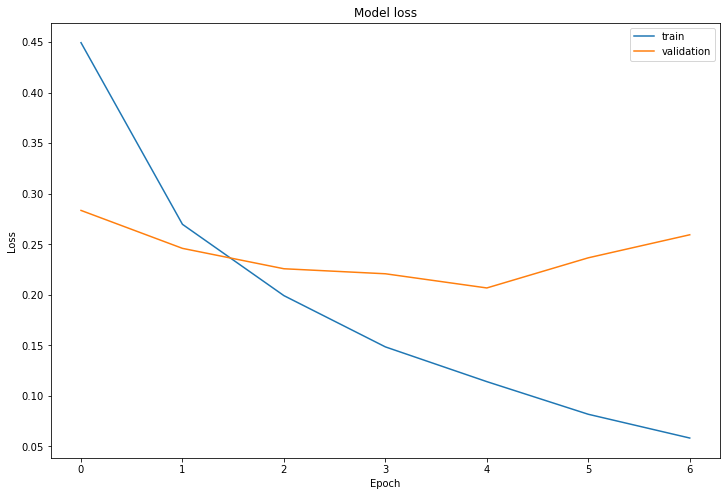

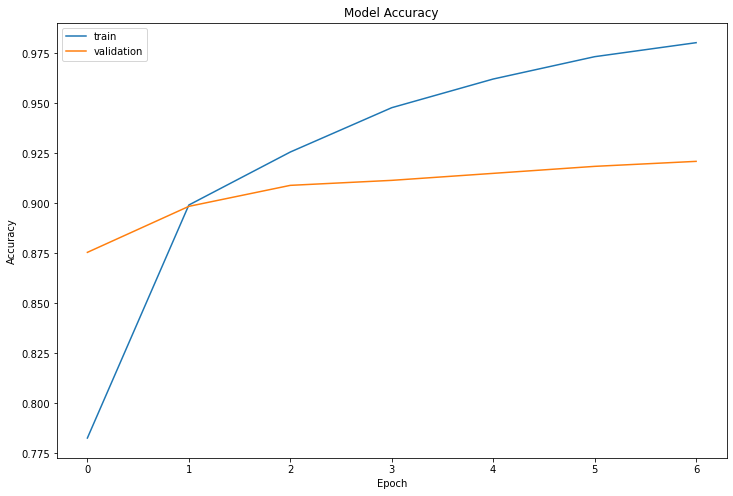

In [12]:
plot_learning_curve(history)

In [13]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)


pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print(X_test[i])
        print('Expected label:'+ str(Y_test[i]))
        print(np.round(pred[i], 3))

63/63 [==============================] - 0s 2ms/step - loss: 0.2409 - accuracy: 0.9190

Test accuracy =  0.9190000295639038
Easily Duped: Trump Surpasses Bush, Falling for ‘Chemical Weapons’ Theatrics
Expected label:1
[0.856 0.144]
Trump open to Dreamers relief legislation without wall funding -aide
Expected label:0
[0.06 0.94]
Australian police say car that hit pedestrians in Melbourne was a deliberate act
Expected label:0
[0.136 0.864]
NSA chief on Russia-U.S. cyber unit: Now is 'not the best time'
Expected label:0
[0.009 0.991]
 WTF? Trump Demanded Comey’s ‘Loyalty’ At Private Dinner
Expected label:1
[0.914 0.086]
WOW! FORMER AMBASSADOR TO RUSSIA Lists Failures Of OBAMA in Syria [VIDEO]
Expected label:1
[0.997 0.003]
TRANSPORTATION SECRETARY: Highway System Targeted Black Neighborhoods [VIDEO]
Expected label:1
[0.98 0.02]
TRUMP SHOCKS SUPPORTERS With SURPRISE Visit At Huge Rally Hosted By “Blacks 4 Trump” Near Mar-a-Lago [VIDEO]
Expected label:1
[0.961 0.039]
U.S. citizen on the run

# Conclusion
- 90% of accuracy in balanced dataset.
- Sign of overfit from 4 epoch.
- Without EDA, we don't know if any bias of dataset played a key role in correct classification. Let's take a look and improve this base model with EDA and hyperparameter tuning.